<a href="https://colab.research.google.com/github/joestrada1022/ASL_CNN_Model/blob/josh_dev/ASL_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Goal:
Our project goal is to use a **CNN** (Convolutional Neural Network) to predict the translations of **American Sign Language**.


### Initialization (Run First)

In [37]:
#Importing required libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, gdown
from google.colab.patches import cv2_imshow #Makes the opencv image display compatible with Jupyter Notebook
from pathlib import Path




In [38]:
import keras
from keras.models import Sequential
from keras.layers import Dense,Flatten,Conv2D,MaxPool2D,Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import save_model, load_model
import tensorflow as tf
from tensorflow.keras.preprocessing import image

## Section 1: Dataset Discovery and Processing

In [39]:
#Loading the combined dataset
input_filename = "/content/dataset/sign_mnist.csv"

# Replace 'file_id' with the ID of your file
file_id = '1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS
From (redirected): https://drive.google.com/uc?id=1NcoMkiEMX3fpPQMcTqsqKSJ1TQczvsVS&confirm=t&uuid=901f6f82-81f0-46aa-9ea4-bdad164b6ef9
To: /content/sign_mnist.csv
100%|██████████| 105M/105M [00:01<00:00, 80.9MB/s]


### **Data Discovery**

In [40]:
dataset = pd.read_csv('/content/dataset/sign_mnist.csv')

print("First 5 values in the dataset:\n" , dataset.head())
print("\nLast 5 values in the dataset:\n" ,dataset.tail())
print("\nSummary of the data:")
print(dataset.info())
print("\nStatistical summary of the data:\n" ,dataset.describe())
print("\n Shape of the dataset:", dataset.shape)

First 5 values in the dataset:
    label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784 

## **Handling Missing values in the dataset**

In [41]:
#NaN values in the dataset ?
nan = dataset.isnull().sum()
print(nan[nan != 0])

Series([], dtype: int64)


### **Analysing the dataset**

In [42]:
#Analyse the pixels intensity values
subset_pixels = dataset.iloc[:, 1:] #Removes labels
subset_pixels.describe()

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,...,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.000000,34627.00000
mean,145.857077,148.903226,151.677824,153.984983,156.616600,158.904121,160.847171,162.610911,164.293384,165.901868,...,140.574985,147.090479,152.791261,158.403211,161.332140,162.097063,161.923528,161.077136,160.211309,158.77919
std,41.839313,40.355637,39.355866,38.762706,37.252215,36.130753,35.274594,34.137995,32.882325,31.514255,...,63.914830,65.438124,64.713282,64.112086,64.055046,63.886450,64.166570,63.892399,64.395504,65.25230
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,122.000000,126.000000,130.000000,133.000000,137.000000,140.000000,143.000000,145.000000,146.000000,148.000000,...,91.500000,96.000000,102.000000,110.000000,118.000000,122.000000,124.000000,124.000000,124.000000,121.00000
50%,151.000000,154.000000,156.000000,158.000000,160.000000,163.000000,164.000000,166.000000,167.000000,168.000000,...,142.000000,161.000000,172.000000,179.000000,183.000000,183.000000,183.000000,182.000000,182.000000,181.00000
75%,175.000000,177.000000,179.000000,180.000000,181.000000,182.000000,184.000000,185.000000,185.000000,186.000000,...,196.000000,202.000000,205.000000,207.000000,208.000000,207.000000,207.000000,206.000000,205.000000,204.00000
max,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,...,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.000000,255.00000


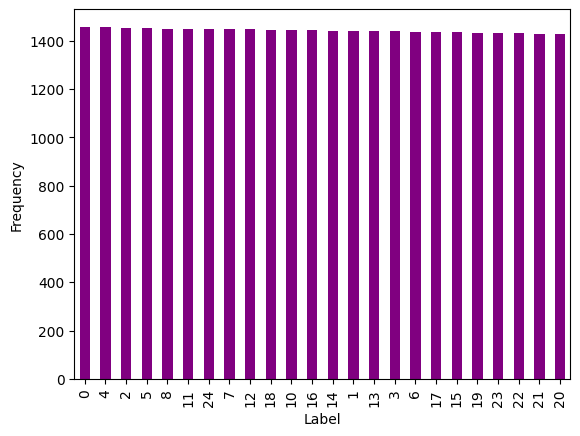

In [43]:
#Distribution of the digits in the dataset
_ = dataset['label'].value_counts().plot(kind = 'bar', color = 'purple')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [44]:
def display_digits(start_index, end_index, dataset):
    """
    Displays handwritten digit images from the dataset
    within the specified range [start_index, end_index].
    """

    images = np.arange(start_index, end_index)  # Setting the range

    subset_images = dataset.iloc[images, :]  # Selects images within that range
    subset_images.index = range(1, end_index - start_index + 1)  # Resets index of subset images to start at 1
    labels = subset_images['label'].values  # Get labels of the selected images
    subset_images.drop(columns=['label'], inplace=True)  # Dropping column from the dataframe

    num_images = end_index - start_index
    rows = (num_images // 8) + 1

    # Converts pixel data to image data
    for i, row in subset_images.iterrows():
        plt.subplot(rows, 8, i)
        pixels = row.values.reshape((28, 28))
        plt.imshow(pixels, cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.title(f"{labels[i-1]}")  # Display label next to each image

    plt.show()


<ipython-input-44-8d6c981fcf1e>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_images.drop(columns=['label'], inplace=True)  # Dropping column from the dataframe


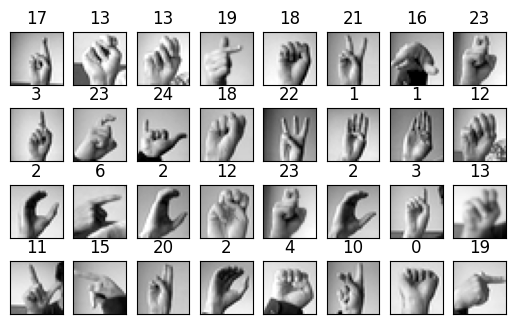

In [45]:
display_digits(16, 48, dataset)

### **Splitting the dataset into training, validating and testing datasets proportionally**

In [46]:
#Initializing target Value/label array and poupulating it with 0 through 25(exclusive) to represent our labels
target_values =  list(range(0, 25))

# Initialize empty dictionaries to store the splits
train_splits = {target: None for target in target_values}
valid_splits = {target: None for target in target_values}
test_splits = {target: None for target in target_values}

# Split the data for each target value
for target in target_values:
    target_data = dataset[dataset['label'] == target]
    train_splits[target] = target_data.sample(frac=0.7)
    valid_splits[target] = target_data.sample(frac=0.1)
    test_splits[target] = target_data.sample(frac=0.2)

# Extract the resulting data splits for each target value
train = pd.concat([train_splits[target] for target in target_values])
val = pd.concat([valid_splits[target] for target in target_values])
test = pd.concat([test_splits[target] for target in target_values])

# #Converting the files to a csv type
# train.to_csv("trainingDataASL.csv", index=False, float_format="%.5f")
# val.to_csv("validatingDataASL.csv", index=False, float_format="%.5f")
# test.to_csv("testingDataASL.csv", index=False, float_format="%.5f")

Split data files stored under content folder


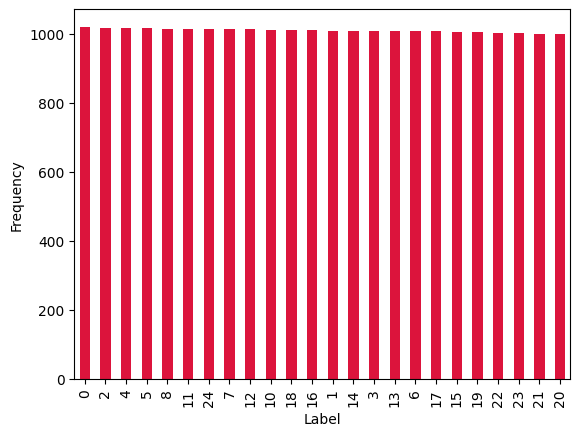

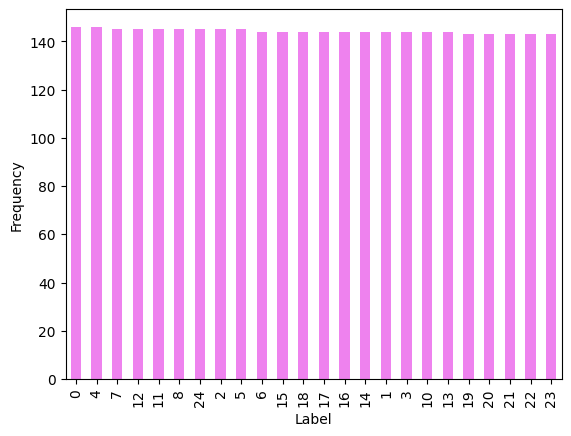

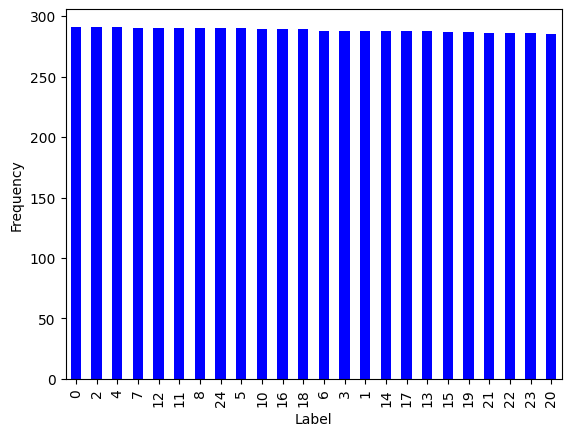

In [47]:
#Distribution of the digits in the training dataset
_ = train['label'].value_counts().plot(kind = 'bar', color = 'crimson')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

#Distribution of the digits in the validating dataset
_ = val['label'].value_counts().plot(kind = 'bar', color = 'violet')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

#Distribution of the digits in the testing dataset
_ = test['label'].value_counts().plot(kind = 'bar', color = 'blue')
plt.xlabel("Label")
plt.ylabel("Frequency")
plt.show()

In [48]:
#Loading the training and validating datasets

trainFile = "/content/dataset/trainingDataASL.csv"
trainID = '1tmakkWkKILZp6RhI13aY2wCY8Urs1OTq'
if not os.path.isfile(trainFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + trainID, trainFile, quiet=False)

validateFile = "/content/dataset/validatingDataASL.csv"
validateID = '1lA-Qz3d0PMkPDaqoetzqOO_DLX8nCdXk'
if not os.path.isfile(validateFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + validateID, validateFile, quiet=False)

testFile = "/content/dataset/testingDataASL.csv"
testID = '1anuMBsprWOrrBJ51NI4WziEh_Ve4EQm1'
if not os.path.isfile(testFile):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + testID, testFile, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1tmakkWkKILZp6RhI13aY2wCY8Urs1OTq
To: /content/trainingDataASL.csv
100%|██████████| 73.5M/73.5M [00:00<00:00, 172MB/s]
Downloading...
From: https://drive.google.com/uc?id=1lA-Qz3d0PMkPDaqoetzqOO_DLX8nCdXk
To: /content/validatingDataASL.csv
100%|██████████| 10.5M/10.5M [00:00<00:00, 84.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1anuMBsprWOrrBJ51NI4WziEh_Ve4EQm1
To: /content/testingDataASL.csv
100%|██████████| 21.0M/21.0M [00:00<00:00, 131MB/s]


### **Scaling/Reshaping the dataset**


In [49]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
def prepare_dataset(data: pd.DataFrame):

  data_label = data['label']
  data_values = data.drop(['label'], axis=1)

  # Reshape dataset to fit into CNN
  X_data = data_values.values
  X_data = data_values.values.reshape(-1, 28, 28, 1)

  # Normalize pixel intensity to 0-1
  X_data = X_data / 255.0

  # One-hot encode labels
  Y_data = lb.fit_transform(data_label)

  return X_data, Y_data



In [50]:
trainData = pd.read_csv('/content/dataset/trainingDataASL.csv')
xTrain, yTrain = prepare_dataset(trainData)
print(xTrain.shape, yTrain.shape)

testData = pd.read_csv('/content/dataset/testingDataASL.csv')
xTest, yTest = prepare_dataset(testData)
print(xTest.shape, yTest.shape)

valData = pd.read_csv('/content/dataset/validatingDataASL.csv')
xVal, yVal = prepare_dataset(valData)
print(xVal.shape, yVal.shape)

(24238, 28, 28, 1) (24238, 24)
(6925, 28, 28, 1) (6925, 24)
(3462, 28, 28, 1) (3462, 24)


## TensorFlow CNN Model


In [51]:
model = Sequential()

# Add convolution layers, relu, and maxpooling
model.add(Conv2D(128, kernel_size=(5,5), strides=1, activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(3,3), strides=2))

model.add(Conv2D(64, kernel_size=(3,3), strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

model.add(Conv2D(32, kernel_size=(2,2), strides=1, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=2))

# Flatten output for fully connected layer
model.add(Flatten())

# Fully connected layer
model.add(Dense(units=512, activation='relu'))
model.add(Dropout(rate=0.15))

# Output layer
model.add(Dense(units=24, activation='softmax'))

In [52]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 128)       3328      
                                                                 
 max_pooling2d (MaxPooling2  (None, 11, 11, 128)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 9, 9, 64)          73792     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 4, 4, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 32)          8224      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 1, 1, 32)          0

In [53]:
# compile model
'''
- Using adam optimizer because adam adjusts the learning rate during training
- Using crossentropy because...
'''
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])



# data batch
train_generator = ImageDataGenerator(rotation_range = 0,
                                  height_shift_range=0.2,
                                  width_shift_range=0.2,
                                  shear_range=0,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')

In [69]:
model.fit(train_generator.flow(xTrain, yTrain, batch_size=128),
          epochs=27, validation_data=(xVal, yVal),
          shuffle=1
          )

Epoch 1/27
190/190 [==============================] - 64s 336ms/step - loss: 0.6223 - accuracy: 0.7901 - val_loss: 0.2863 - val_accuracy: 0.8989
Epoch 2/27
190/190 [==============================] - 65s 343ms/step - loss: 0.6209 - accuracy: 0.7901 - val_loss: 0.3141 - val_accuracy: 0.8888
Epoch 3/27
190/190 [==============================] - 67s 352ms/step - loss: 0.5977 - accuracy: 0.7975 - val_loss: 0.2395 - val_accuracy: 0.9220
Epoch 4/27
190/190 [==============================] - 66s 346ms/step - loss: 0.5807 - accuracy: 0.8043 - val_loss: 0.2342 - val_accuracy: 0.9185
Epoch 5/27
190/190 [==============================] - 70s 367ms/step - loss: 0.5872 - accuracy: 0.8028 - val_loss: 0.2506 - val_accuracy: 0.9151
Epoch 6/27
190/190 [==============================] - 68s 358ms/step - loss: 0.5632 - accuracy: 0.8080 - val_loss: 0.2501 - val_accuracy: 0.9102
Epoch 7/27
190/190 [==============================] - 77s 406ms/step - loss: 0.5407 - accuracy: 0.8167 - val_loss: 0.1995 - val_ac

In [75]:
# save for future use
model.save("model.keras")

In [ ]:
#Loading the combined dataset
input_filename = "/content/model1.keras"
# Replace 'file_id' with the ID of your file
file_id = '1jl-9E-0yJhH2z4bja99Zzf2Mqw5TsVGH'
if not os.path.isfile(input_filename):
  # Downloading the file
  gdown.download('https://drive.google.com/uc?id=' + file_id, input_filename, quiet=False)

model = load_model('/content/model1.keras')

Downloading...
From: https://drive.google.com/uc?id=1jl-9E-0yJhH2z4bja99Zzf2Mqw5TsVGH
To: /content/model1.keras
100%|██████████| 4.37M/4.37M [00:00<00:00, 52.6MB/s]


In [70]:
(testing_loss, testing_accuracy)=model.evaluate(xTest,yTest,batch_size=128)
print(f"Testing Loss: {testing_loss:.4f}, Testing Accuracy: {testing_accuracy:.4f}")
print('MODEL ACCURACY = {}%'.format(testing_accuracy*100))

55/55 [==============================] - 4s 64ms/step - loss: 0.1438 - accuracy: 0.9467
Testing Loss: 0.1438, Testing Accuracy: 0.9467
MODEL ACCURACY = 94.67148184776306%


In [58]:
def get_prediction(image_path: str, Model, num_pred: int = 3):
  hand = cv2.imread(image_path)
  gray = cv2.cvtColor(hand, cv2.COLOR_BGR2GRAY)

  reshaped = cv2.resize(gray, (28, 28))
  cv2_imshow(reshaped)
  reshaped = np.expand_dims(reshaped, axis=0)
  reshaped = reshaped / 255
  reshaped = reshaped.reshape(-1, 28, 28, 1)

  predictions = Model.predict(reshaped)
  # print(predictions)
  indices = tf.math.top_k(predictions, k=num_pred).indices.numpy()
  class_labels = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y']
  preds = ''
  for i in range(len(predictions)):
    for j in range(num_pred):
        class_index = indices[i][j]
        class_label = class_labels[class_index]
        confidence = predictions[i][class_index]
        preds += (f"{j+1}: {class_label}: ({confidence:.2f})") + ' '

  plt.imshow(cv2.cvtColor(hand, cv2.COLOR_BGR2RGB))
  plt.title(preds)
  plt.axis('off')
  plt.show()

# Testing Outputs

1/1 [==============================] - 0s 21ms/step


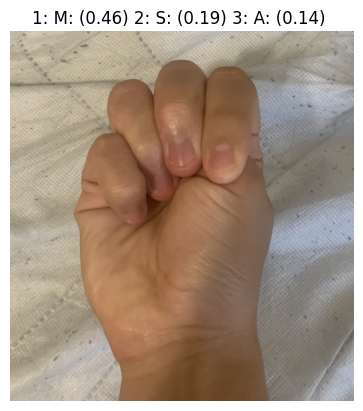

In [71]:
get_prediction('/dataset/joshM.jpg', model)

1/1 [==============================] - 0s 32ms/step


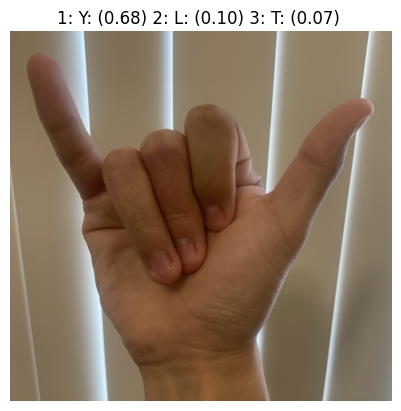

In [72]:
get_prediction('/dataset/joshY.jpg', model)

1/1 [==============================] - 0s 20ms/step


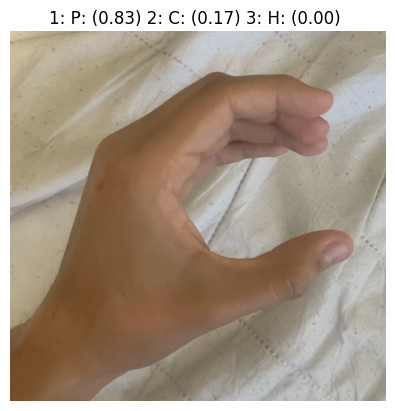

In [73]:
get_prediction('/dataset/joshC.jpg', model)

1/1 [==============================] - 0s 22ms/step


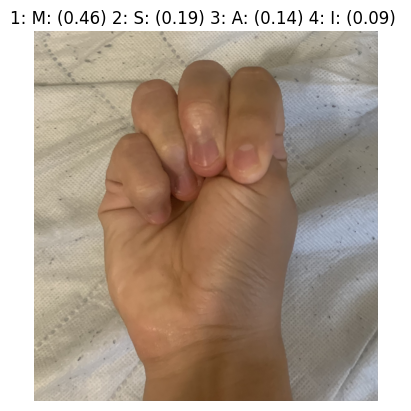

In [74]:
get_prediction('/dataset/joshM.jpg', model, 4)